In [34]:
image_name = 'images/receipt_creased.jpeg'

In [35]:
import cv2
from matplotlib import pyplot as plt
from math import ceil
import numpy as np
import operator

def show(title, image, color=None):
    plt.figure(figsize = (15,15))
    plt.title(title)
    if color is None:
        plt.imshow(image)
    else:
        plt.imshow(image, cmap=color)
    plt.show()
    

In [36]:
def preprocess_image(image, skip_dilate=False, skip_invert=False):
    a = cv2.GaussianBlur(image.copy(), (9, 9), 0)
    b = cv2.adaptiveThreshold(a.copy(), 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    c = cv2.bitwise_not(b.copy(), b.copy())
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
    d = cv2.dilate(c.copy(), kernel)
    return d

In [37]:
def find_corners_of_largest_polygon(img):
    """Finds the 4 extreme corners of the largest contour in the image."""
    contours, _ = cv2.findContours(img.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)  # Find contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)  # Sort by area, descending
    polygon = contours[0]  # Largest image

    # Use of `operator.itemgetter` with `max` and `min` allows us to get the index of the point
    # Each point is an array of 1 coordinate, hence the [0] getter, then [0] or [1] used to get x and y respectively.

    # Bottom-right point has the largest (x + y) value
    # Top-left has point smallest (x + y) value
    # Bottom-left point has smallest (x - y) value
    # Top-right point has largest (x - y) value
    bottom_right, _ = max(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_left, _ = min(enumerate([pt[0][0] + pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    bottom_left, _ = min(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))
    top_right, _ = max(enumerate([pt[0][0] - pt[0][1] for pt in polygon]), key=operator.itemgetter(1))

    # Return an array of all 4 points using the indices
    # Each point is in its own array of one coordinate
    return [polygon[top_left][0], polygon[top_right][0], polygon[bottom_right][0], polygon[bottom_left][0]]

In [38]:
def distance_between(p1, p2):
    """Returns the scalar distance between two points"""
    a = p2[0] - p1[0]
    b = p2[1] - p1[1]
    return np.sqrt((a ** 2) + (b ** 2))


def crop_and_warp(param_img, crop_rect):
    """Crops and warps a rectangular section from an image into a square of similar size."""

    # Rectangle described by top left, top right, bottom right and bottom left points
    top_left, top_right, bottom_right, bottom_left = crop_rect[0], crop_rect[1], crop_rect[2], crop_rect[3]

    # Explicitly set the data type to float32 or `getPerspectiveTransform` will throw an error
    src = np.array([top_left, top_right, bottom_right, bottom_left], dtype='float32')

    # Get the longest side in the rectangle
    side = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])
    
    width = max([
        distance_between(bottom_right, bottom_left),
        distance_between(top_left, top_right)
    ])

    height = max([
        distance_between(bottom_right, top_right),
        distance_between(top_left, bottom_left),
    ])
    
    # Describe a rectangle with calculated width and height, this is the new perspective we want to warp to
    dst = np.array([[0, 0], [width - 1, 0], [width - 1, height - 1], [0, height - 1]], dtype='float32')

    # Gets the transformation matrix for skewing the image to fit a square by comparing the 4 before and after points
    m = cv2.getPerspectiveTransform(src, dst)

    # Performs the transformation on the original image
    return cv2.warpPerspective(param_img.copy(), m, (int(width), int(height)))

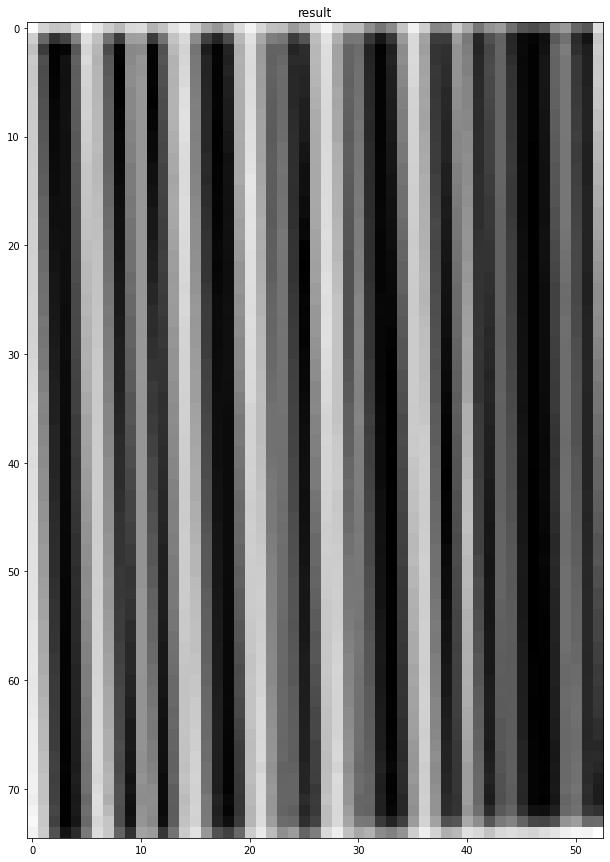

In [39]:
original = cv2.imread(image_name, cv2.IMREAD_GRAYSCALE)
processed = preprocess_image(original)
corners = find_corners_of_largest_polygon(processed)

cropped_original = crop_and_warp(original, corners)
show("result", cropped_original, "gray")

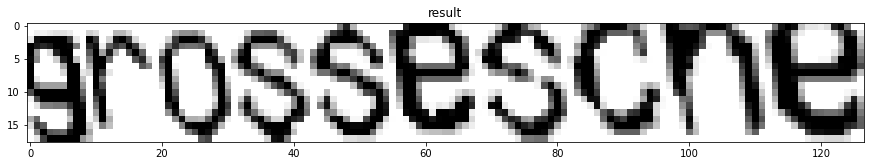

In [40]:
for name in ["receipt_clean.png"]:
    original = cv2.imread(f"images/{name}", cv2.IMREAD_GRAYSCALE)
    processed = preprocess_image(original.copy())
    corners = find_corners_of_largest_polygon(processed.copy())

    underlying = cv2.imread(f"images/{name}", cv2.IMREAD_GRAYSCALE)
    _, th = cv2.threshold(underlying.copy(), 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    
    result = crop_and_warp(th.copy(), corners)
    show("result", result.copy(), "gray")

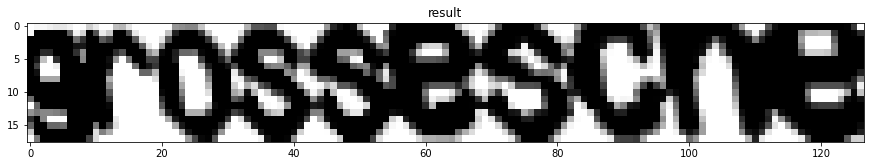

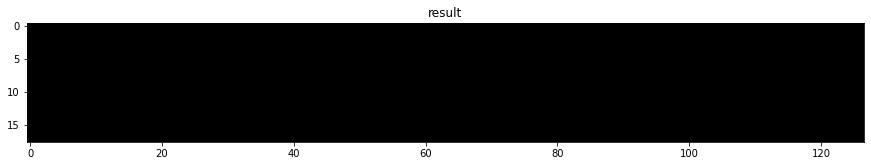

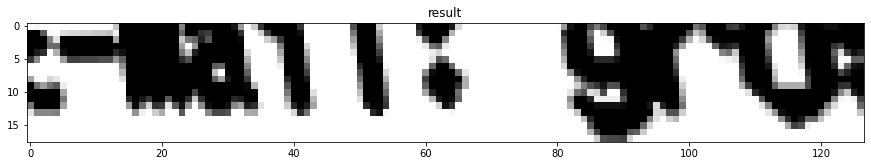

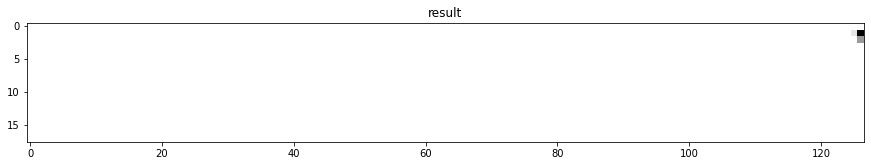

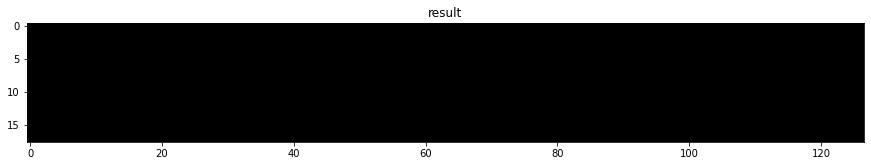

In [19]:
for image_name in ["receipt_clean.png", "receipt_creased.jpeg", "receipt_edges.jpeg",
                  "receipt_hard.jpg", "receipt_large.jpeg"]:
    img = cv2.imread(f"images/{image_name}", cv2.IMREAD_GRAYSCALE)
    #img = cv2.GaussianBlur(img, (5, 5), 0)
    _, otsu = cv2.threshold(img,0,255,cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    inverse = cv2.bitwise_not(otsu, otsu)
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
    dilated = cv2.dilate(inverse, kernel)
    inverse = cv2.bitwise_not(dilated, dilated)
    cropped_otsu = crop_and_warp(dilated, corners)
    show("result", cropped_otsu, "gray")

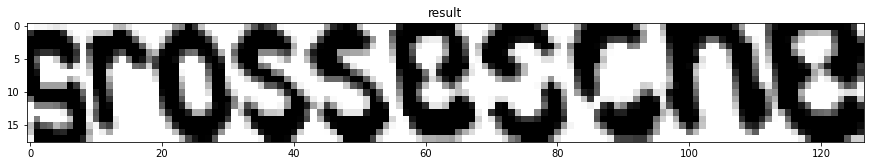

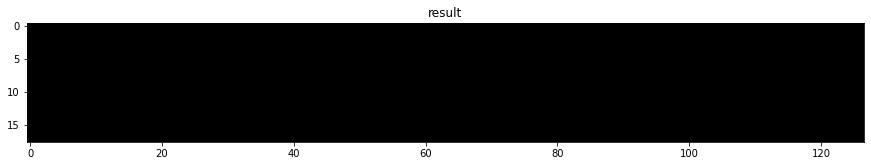

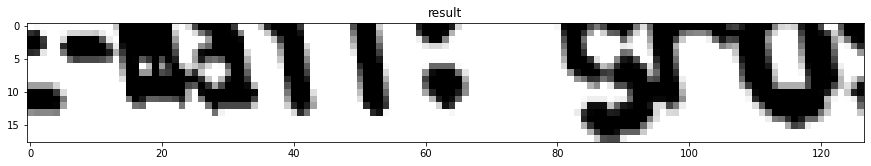

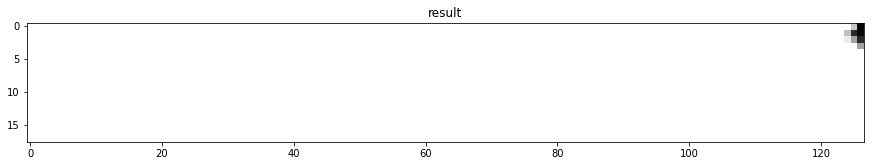

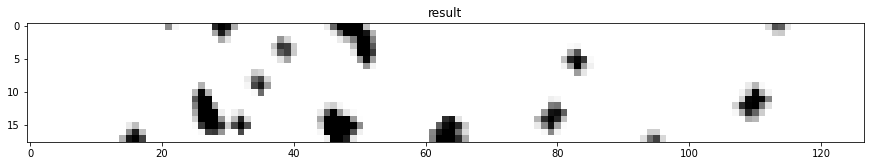

In [20]:
for image_name in ["receipt_clean.png", "receipt_creased.jpeg", "receipt_edges.jpeg",
                  "receipt_hard.jpg", "receipt_large.jpeg"]:
    img = cv2.imread(f"images/{image_name}", cv2.IMREAD_GRAYSCALE)
    img = cv2.GaussianBlur(img, (9, 9), 0)
    th = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    inverse = cv2.bitwise_not(th, th)
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
    eroded = cv2.erode(inverse, kernel)
    dilated = cv2.dilate(eroded, kernel)
    inverse = cv2.bitwise_not(dilated, dilated)
    cropped = crop_and_warp(dilated, corners)
    show("result", cropped, "gray")


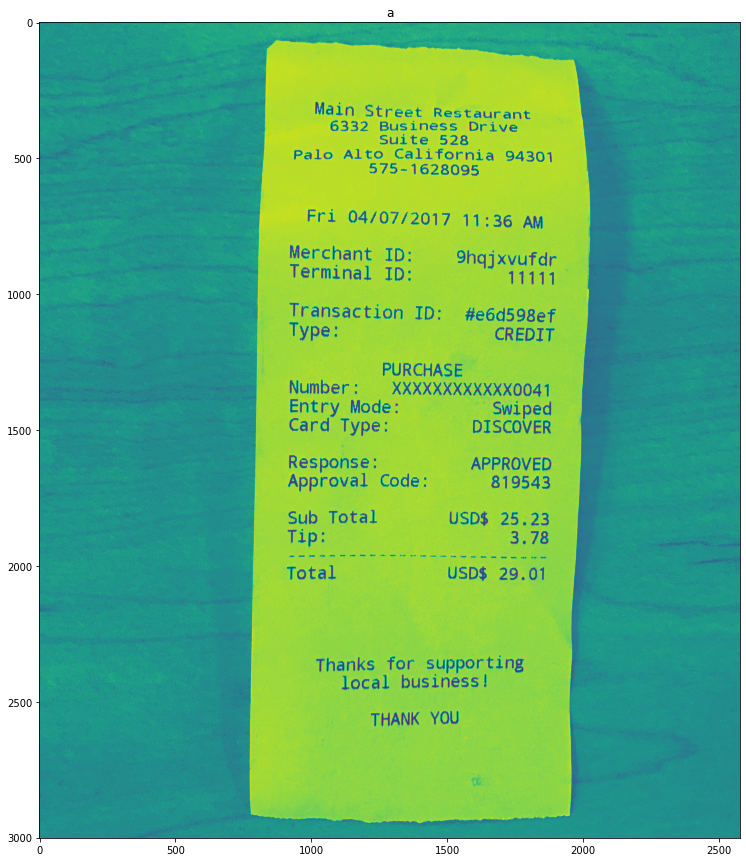

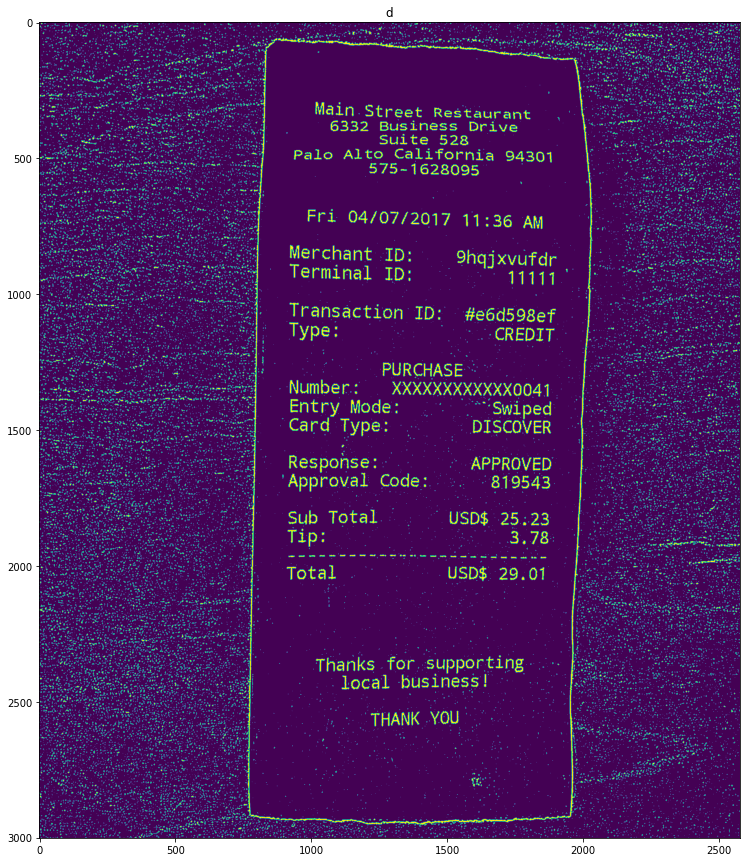

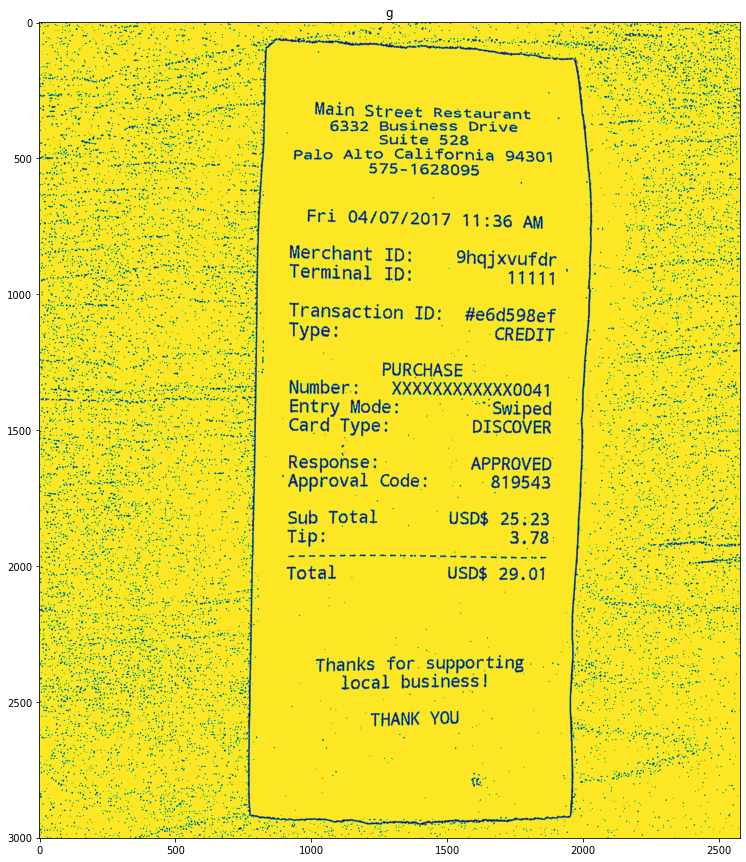

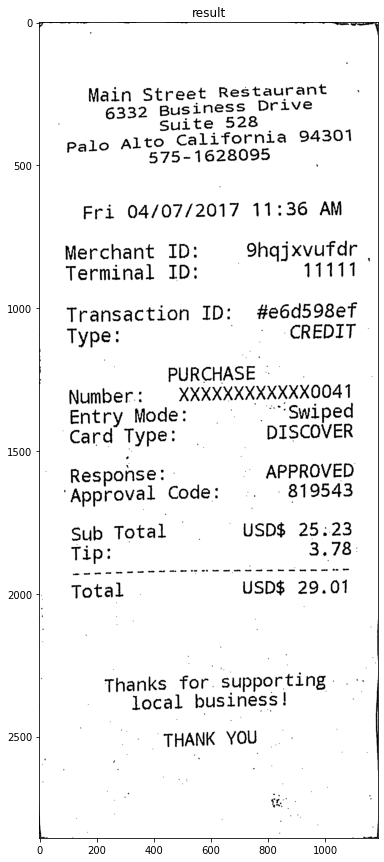

In [10]:
for image_name in ["receipt_large.jpeg"]:
    a = cv2.imread(f"images/{image_name}", cv2.IMREAD_GRAYSCALE)
    show("a", a)
    b = cv2.GaussianBlur(a, (9, 9), 0)
    c = cv2.adaptiveThreshold(b, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 11, 2)
    d = cv2.bitwise_not(c, c)
    show("d", d)
    kernel = np.array([[0, 1, 0], [1, 1, 1], [0, 1, 0]], np.uint8)
    e = cv2.erode(d, kernel)
    f = cv2.dilate(e, kernel)
    g = cv2.bitwise_not(f, f)
    show("g", g)
    cropped = crop_and_warp(g, corners)
    show("result", cropped, "gray")
